Import all necessary packages

In [11]:
import numpy as np ### numpy for array modifications
import pandas as pd ### pandas for dataframe handling
import seaborn as sns ### seaborn for data vis
from sklearn.linear_model import LinearRegression ### regression model from skleanr

from nba_api.stats.static import players ### all nba players -- not box score data, just player IDs
from nba_api.stats.static import teams ### all nba teams -- not box score data, just teans IDs
from nba_api.stats.endpoints import playergamelog ### player game stats
from nba_api.stats.endpoints import leaguegamefinder ### team game stats
from nba_api.stats.endpoints import teamgamelog ### team game logs
from nba_api.stats.endpoints import teamvsplayer ### team to player

Creating a dictionary of all players all time.

In [12]:
player_dict = players.get_players() 

Creating a dictionary of all active players.

In [13]:
active_player_dict = [player for player in player_dict if player['is_active'] ==  True]

A function that finds the player id given the player name.

The parameter player_name is a string.

The output is the corresponding players's id as an int.

In [14]:
def player_id_finder(player_name):
    for player in active_player_dict:
        if player['full_name'] == player_name:
            return player['id']

The below creates a dictionary, pairing each team's abbreviation with the full team name.

In [15]:
x = ['ATL', 'BOS', 'BKN', 'CHA', 'CHI', 'CLE', 'DAL', 'DEN', 'DET', 'GSW', 'HOU', 'IND', 'LAC', 'LAL', 'MEM', 'MIA', 'MIL', 'MIN', 'NOP', 'NYK', 'OKC', 'ORL', 'PHI', 'PHX', 'POR', 'SAC', 'SAS', 'TOR', 'UTA', 'WAS']
y = ['Atlanta Hawks','Boston Celtics','Brooklyn Nets','Charlotte Hornets','Chicago Bulls','Cleveland Cavaliers','Dallas Mavericks','Denver Nuggets','Detroit Pistons','Golden State Warriors','Houston Rockets','Indiana Pacers','Los Angeles Clippers','Los Angeles Lakers','Memphis Grizzlies','Miami Heat','Milwaukee Bucks','Minnesota Timberwolves','New Orleans Pelicans','New York Knicks','Oklahoma City Thunder','Orlando Magic','Philadelphia 76ers','Phoenix Suns','Portland Trail Blazers','Sacramento Kings','San Antonio Spurs','Toronto Raptors', 'Utah Jazz', 'Washington Wizards']
team_name_dict = {k:v for k, v in zip(x,y)}

Creating a dictionary of all teams.

In [16]:
team_dict = teams.get_teams()

A function that finds the team id given the team name.

The parameter team_name is a string.

The output is the corresponding team's id as an int.

In [17]:
def team_id_finder(team_name):
    for team in team_dict:
        if team['full_name'] == team_name:
            return team['id']

A function that calculates a given teams offensive rating for all games played and average of all games.

The parameters
- season: str
- season_type: str ('Regular Season', 'Playoffs')
- team_name: str

The Output
- average offensive team rating for the season


In [18]:
def avg_off_team_rating(season, season_type, team_name):
    gamelogs = teamgamelog.TeamGameLog(season = season, season_type_all_star = season_type, team_id = team_id_finder(team_name)).get_data_frames()[0]
    gamelogs.loc[:,'ORating'] = (gamelogs['PTS'])/(gamelogs['FGA'] - gamelogs['OREB'] + gamelogs['TOV'] + 0.4 * gamelogs['FTA']) * 100
    return gamelogs['ORating'].mean()

A function that calculatest the opponents offensive rating for each game the player has played in a season.

The parameters
- player_name: str
- season: str
- season_type: str ('Regular Season', 'Playoffs')

The output:
- a df with all the games a player played in a season along with the offensive rating of the opposing team that game and the season average offensive rating of that team 

This needs to be fixed. Makes too many API calls and causes runtime errors. Also the Opponent Offensive Rating is not a good predictor. But a good start to testing what works and doesn't.

In [19]:
def opp_avg_off_rating_df(player_name, season, season_type):
    print('starting:')
    player_gamelog = playergamelog.PlayerGameLog(player_id = str(player_id_finder(player_name)), season = season).get_data_frames()[0]
    print('player gamelog accessed')
    
    unique_teams = player_gamelog['MATCHUP'].str[-3:].map(team_name_dict).unique()
    print('Unique teams extracted:', len(unique_teams))
                                                          
    team_gamelogs ={}
    k = 1
    for team in unique_teams:
        team_gamelogs[team] = avg_off_team_rating(season, season_type, team)
        print('Team gamelogs retrieved:', k)
        k += 1
                                                          
    i = 0
    for opponent in player_gamelog['MATCHUP'].str[-3:]:
        player_gamelog.loc[i, 'OppOffRating'] = team_gamelogs[team_name_dict[opponent]]
        i += 1
        
    return sns.lmplot(data=player_gamelog, x='OppOffRating', y='PTS')
                                                          
    

In [20]:
#Opp_Off_Rating_Pts_Model = opp_avg_off_rating_df('LeBron James', '2022', 'Regular Season')

A function that saves team data by season as a csv file.

The parameters
- seasons_list: list (of seasons in format [20xx-xx, 20xx-xx, ...]
- season_type: str ('Regular Season', 'Playoffs')

The Output
- saves the dataframe created from the API call as a csv file (no output)

In [21]:
def save_team_datasets(seasons_list, season_type):
    for season in seasons_list:
        print('loading season', season)
        df = leaguegamefinder.LeagueGameFinder(season_nullable = season, league_id_nullable = '00', season_type_nullable = season_type).get_data_frames()[0]
        filename = str(season) + 'teams.csv'
        df.to_csv(filename, index=False)
        print('Successully saved', filename)

In [22]:
def save_player_datasets(seasons_list, season_type):
    for season in seasons_list:
        print('loading season', season)
        df = leaguegamefinder.LeagueGameFinder(player_or_team_abbreviation='P' ,season_nullable = season, league_id_nullable = '00', season_type_nullable = season_type).get_data_frames()[0]
        filename = str(season) + 'players.csv'
        df.to_csv(filename, index=False)
        print('Successully saved', filename)

In [23]:
seasons_list = ['2018-19', '2019-20', '2020-21', '2021-22', '2022-23']

save_team_datasets(seasons_list, 'Regular Season')

loading season 2018-19
Successully saved 2018-19teams.csv
loading season 2019-20
Successully saved 2019-20teams.csv
loading season 2020-21
Successully saved 2020-21teams.csv
loading season 2021-22
Successully saved 2021-22teams.csv
loading season 2022-23
Successully saved 2022-23teams.csv


In [24]:
save_player_datasets(seasons_list, 'Regular Season')

loading season 2018-19
Successully saved 2018-19players.csv
loading season 2019-20
Successully saved 2019-20players.csv
loading season 2020-21
Successully saved 2020-21players.csv
loading season 2021-22
Successully saved 2021-22players.csv
loading season 2022-23
Successully saved 2022-23players.csv


In [25]:
players_2023 = pd.read_csv('2022-23players.csv')

In [26]:
teams_2023 = pd.read_csv('2022-23teams.csv')

In [27]:
def stl_tov_trends(team_name, teams_df):

    #retrieve the stats from the teams in all the games the team played in
    team_games = teams_df[teams_df['TEAM_NAME']==team_name]
    team_game_ids = list(team_games['GAME_ID'])
    opp_team_games = teams_df[teams_df['GAME_ID'].isin(team_game_ids)]
    opp_team_tovs = opp_team_games[opp_team_games['TEAM_ID'] != team_id_finder(team_name)]
    
    #retrieve turnovers and steals
    
    opp_tovs = np.array(opp_team_tovs['TOV'])
    
                                       
    #create a dictionary mapping the game ids to the def ratings.
    id_tov_stl_dict = {k:v for k,v in zip(team_game_ids, opp_tovs)}

    #map the opponent defensive rating onto player_df
    team_games.loc[:, 'opp_tovs'] = team_games['GAME_ID'].map(id_tov_stl_dict)

    #plot regression lines and find basic stats.
    x = np.array(team_games['opp_tovs']).reshape(-1, 1)
    y = np.array(team_games['STL'])
    
    sns.lmplot(data=team_games, x='opp_tovs', y='STL')
    stls_model = LinearRegression().fit(x, y)
    print('R-squared for pts:', stls_model.score(x,y))

R-squared for pts: 0.5397955313807437


/var/folders/t_/6pr35fg96s7cpgmqrdcyy3p40000gq/T/ipykernel_11009/965023398.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  team_games.loc[:, 'opp_tovs'] = team_games['GAME_ID'].map(id_tov_stl_dict)


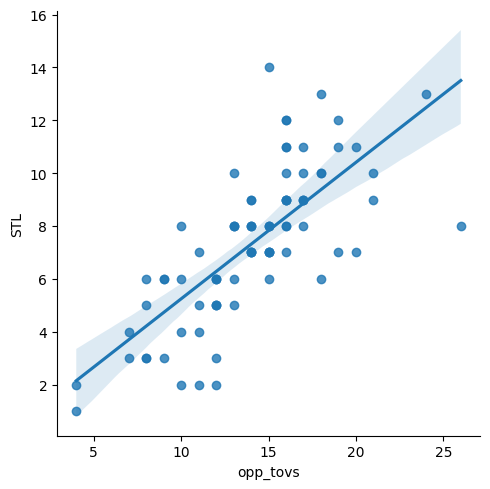

In [28]:
stl_tov_trends('Orlando Magic', teams_2023)

In [29]:
def points_to_tovs(team, teams_df):
    
    team_df = teams_2023[teams_df['TEAM_NAME'] == team]
    
    x = np.array(teams_df['REB']).reshape(-1,1)
    y = np.array(teams_df['PTS'])
    
    sns.lmplot(data=team_df, x='REB', y='PTS')
    model = LinearRegression().fit(x,y)
    print('R-squared for Model:', model.score(x,y))

In [30]:
def steals_to_tovs(team, teams_df):
    
    team_df = teams_2023[teams_df['TEAM_NAME'] == team]
    
    x = np.array(teams_df['REB']).reshape(-1,1)
    y = np.array(teams_df['PTS'])
    
    sns.lmplot(data=team_df, x='REB', y='PTS')
    model = LinearRegression().fit(x,y)
    print('R-squared for Model:', model.score(x,y))

In [31]:
def player_points_prediction_model(player_name, players_df, teams_df):
    #create player_df from players_df
    player_df = players_df[players_df['PLAYER_NAME'] == player_name].copy()
    
    #extract player game IDs
    player_game_ids = list(player_df['GAME_ID'])
    
    #extract team (opponent and team that player is on) data from games that player played in
    player_games = teams_df[teams_df['GAME_ID'].isin(player_game_ids)].copy()
    
    #extract team IDs of all the teams that the player was on during the season
    player_team_ids = set(list(player_df['TEAM_ID']))
    
    #create df of stats from the teams that the player played on only (not opposing teams' data)
    player_team_games = player_games[player_games['TEAM_ID'].isin(player_team_ids)].copy()
    
    #ex
    
    #extract team fga from player_team_games
    team_fga = list(player_team_games['FGA'])
    
    #create a dictionary linking player_game_ids to team FGA
    game_id_team_fga_dict = {k:v for k,v in zip(player_game_ids, team_fga)}
    
    #map team_fga to player_df
    player_df.loc[:, 'team_fga'] = player_df['GAME_ID'].map(game_id_team_fga_dict)
    
    #calculate the percentage of the teams field goal attempts a player takes (FACTOR 1)
    player_df.loc[:, 'playerFGA%'] = player_df['FGA']/player_df['team_fga']
    
    #calculate the players eFG% (FACTOR 2)
    player_FGM = np.array(player_df['FGM'])
    player_ThreePM = np.array(player_df['FG3M'])
    player_FGA = np.array(player_df['FGA'])
    
    player_df.loc[:, 'eFG%'] = (player_FGM + (0.5 * player_ThreePM))/player_FGA
    
    #define the variables
    x = player_df[['playerFGA%', 'eFG%', 'FTA', 'FT_PCT']].fillna(0)
    y = player_df['PTS']
    
    model = LinearRegression().fit(x,y)
    
    return model

In [32]:
bron_points_model = player_points_prediction_model('LeBron James', players_2023, teams_2023)

In [33]:
bron_points_model.predict([[0.20, 0.65, 5, 0.70]])

/Users/rafirafi/Desktop/git-repos/nba-sports-betting-predictor-1/nba-predictions/lib/python3.11/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


array([27.64282324])

In [34]:
def player_points_prediction_test_data(player_name, players_df, teams_df):
    #create player_df from players_df
    player_df = players_df[players_df['PLAYER_NAME'] == player_name].copy()
    
    #extract player game IDs
    player_game_ids = list(player_df['GAME_ID'])
    
    #extract team (opponent and team that player is on) data from games that player played in
    player_games = teams_df[teams_df['GAME_ID'].isin(player_game_ids)].copy()
    
    #extract team IDs of all the teams that the player was on during the season
    player_team_ids = set(list(player_df['TEAM_ID']))
    
    #create df of stats from the teams that the player played on only (not opposing teams' data)
    player_team_games = player_games[player_games['TEAM_ID'].isin(player_team_ids)].copy()
    
    #extract team fga from player_team_games
    team_fga = list(player_team_games['FGA'])
    
    #create a dictionary linking player_game_ids to team FGA
    game_id_team_fga_dict = {k:v for k,v in zip(player_game_ids, team_fga)}
    
    #map team_fga to player_df
    player_df.loc[:, 'team_fga'] = player_df['GAME_ID'].map(game_id_team_fga_dict)
    
    #calculate the percentage of the teams field goal attempts a player takes (FACTOR 1)
    player_df.loc[:, 'playerFGA%'] = player_df['FGA']/player_df['team_fga']
    
    #calculate the players eFG% (FACTOR 2)
    player_FGM = np.array(player_df['FGM'])
    player_ThreePM = np.array(player_df['FG3M'])
    player_FGA = np.array(player_df['FGA'])
    
    player_df.loc[:, 'eFG%'] = (player_FGM + (0.5 * player_ThreePM))/player_FGA
    
    return player_df

In [35]:
def test_prediction_model(player_name, playersRegular_df, teamsRegular_df, playersPlayoff_df, teamsPlayoff_df, prediction_model, test_data):
    # create model
    model = prediction_model(player_name, playersRegular_df, teamsRegular_df)
    
    # extract playoff test data
    test_df = test_data(player_name, playersPlayoff_df, teamsPlayoff_df)
    
    # collect x and y test data. 
    # X is the data that we feed into the model. 
    # Y is the actual outcome to compare against the predicted values.
    x_test = test_df[['playerFGA%', 'eFG%', 'FTA', 'FT_PCT']].fillna(0)
    y_test = np.array(test_df['PTS'])
    
    # Generate the predictions.
    y_pred = model.predict(x_test)
    
    # Create a graph to visualize the results
    plt.scatter(y_test, y_pred)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
    plt.xlabel('Actual Points scored by' + player_name)
    plt.ylabel('Predicted Points scored by' +  player_name)
    plt.show()
    
    #Calculate the Mean Squared Error (MSE)
    mse = mean_squared_error(y_test, y_pred)
    print('Mean Squared Error:', mse)
    
    #Calculate the R-Squared
    r2 = r2_score(y_test, y_pred)
    print('R-squared:', r2)

In [36]:
test_prediction_model('LeBron James', players_2023, teams_2023, players_2023_playoffs, teams_2023_playoffs, player_points_prediction_model, player_points_prediction_test_data)

NameError: name 'players_2023_playoffs' is not defined